In [1]:
import pandas as pd
import numpy as np
import os
import tarfile
import urllib
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit,train_test_split,StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

PROJECT_ROOT="."
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/chugh007/CreditCard_FraudDetection/master/"
dataset_path = os.path.join(PROJECT_ROOT,"datasets","downloaded_dataset")
DATASET_URL = DOWNLOAD_ROOT + os.path.join("datasets","creditcard.tar.gz")


In [2]:
def fetch_dataset(url=DATASET_URL,path=dataset_path):
    os.makedirs(dataset_path,exist_ok=True)
    tar_path = os.path.join(dataset_path,"creditcard.tar.gz")
    print("Downloading the dataset from {}".format(url))
    urllib.request.urlretrieve(url,tar_path)
    with tarfile.open(tar_path) as creditcard_tar:
        creditcard_tar.extractall(path=path)
    return pd.read_csv(os.path.join(path,"creditcard.csv"))



In [3]:
creditcard = fetch_dataset()
creditcard

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [4]:
creditcard

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [5]:
creditcard.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [17]:
creditcard['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

As we can see there are only 492 fraud cases among 284807 samples

In [18]:
creditcard.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Lets Analyse time first. In Data description Time contains the seconds elapsed between each transaction and the first transaction in the dataset. 

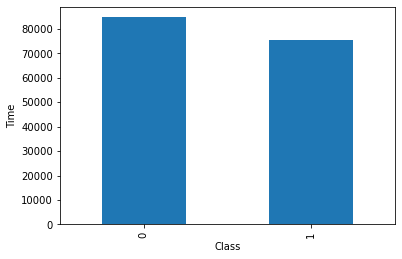

In [33]:
creditcard.groupby('Class')['Time'].median().plot.bar()
plt.xlabel('Class')
plt.ylabel('Time')
plt.show()

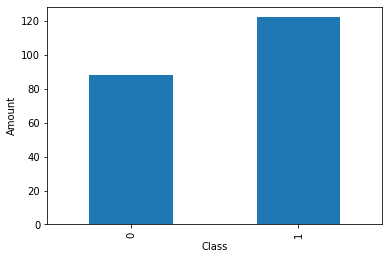

In [34]:
creditcard.groupby('Class')['Amount'].mean().plot.bar()
plt.xlabel('Class')
plt.ylabel('Amount')
plt.show()

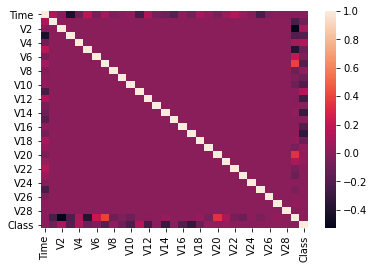

In [40]:
sns.heatmap(creditcard.corr())
plt.show()

Lets divide the dataset in train and test set based on class. 
## Anomaly detection

Based on Andrew Ng anomaly detection technique , we should put anomalous data in our test and validation set and not in training set . So here we will add 50% anomolous samples in test set and 50% in validation set

In [9]:
#spliting only non-anomolous examples
credit_train,credit_testsplit = train_test_split(creditcard[creditcard['Class'] == 0],test_size=0.1,random_state=42)
credit_test,credit_val = train_test_split(credit_testsplit,test_size=0.5,random_state=42)
print("Train size {} \n Validation Size {}\n Test Size {}".format(
    credit_train.shape,credit_val.shape,credit_test.shape
))

Train size (255883, 31) 
 Validation Size (14216, 31)
 Test Size (14216, 31)


Now non-anomolous examples are split across train,test,validation sets .  Now we will take anomolous data and add  it to validation and test set in 50 % ratio

In [15]:
credit_test_anomolous,credit_val_anomolous = train_test_split(creditcard[creditcard['Class'] == 1],test_size=0.5,random_state=42)

credit_test = credit_test.append(credit_test_anomolous)
credit_val = credit_val.append(credit_val_anomolous)

print("Train size {} \n Validation Size {}\n Test Size {}".format(
    credit_train.shape,credit_val.shape,credit_test.shape
))

Train size (255883, 31) 
 Validation Size (14462, 31)
 Test Size (14462, 31)


In [25]:
for index,(name,data) in enumerate(zip(["train","validation","test"],[credit_train,credit_val,credit_test])):
    print("{} set : \n{}".format(name,data['Class'].value_counts()))
    print("-"*10)

train set : 
0    255883
Name: Class, dtype: int64
----------
validation set : 
0    14216
1      246
Name: Class, dtype: int64
----------
test set : 
0    14216
1      246
Name: Class, dtype: int64
----------


In [28]:
X_train,X_val,X_test,y_train,y_val,y_test = credit_train.drop('Class',axis=1),credit_val.drop('Class',axis=1),credit_test.drop('Class',axis=1),credit_train['Class'].copy(),credit_val['Class'].copy(),credit_test['Class'].copy()

X_train.shape

(255883, 30)

Using BayesianMixture we will find the right no of clusters for the data

In [29]:
bayesian_pipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('bayesian',BayesianGaussianMixture(n_components=10,n_init=10))
])
bayesian_pipeline.fit(X_train)


In [ ]:
bayesian_pipeline.weights_
